In [6]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt 

from src.features import build_features

import logging 
from pathlib import Path

import scipy
import pickle
import datetime
import numpy as np

logging.basicConfig(level=logging.INFO)

In [14]:
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.matutils import Sparse2Corpus
from gensim.corpora import Dictionary

from src.data.DBConnection import DBConnection
db = DBConnection()

# Build Features
Use the build_features functions to build dataset from database (usually takes ~1 min)

In [10]:
sql = "SELECT details FROM positions;"
query = db.cur.execute(sql)
documents = query.fetchall()

In [11]:
import re
import gensim
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from src.data.make_dataset import lematize

def process_documents(documents):
    # try new preprocessing steps:
    data = list(documents)
    # remove \n
    data = [text[0].replace("\n", " ") for text in data]
    # remove https:// links 
    data = [re.sub(r"((https{0,1}\:/\/\w{3}\S+)|(w{3}\S+))", "", text) for text in data]
    # remove emails:
    data = [re.sub(r"(\S+@\S+)", "", text) for text in data]
    # remove phone numbers:
    data = [re.sub(r"([\+\s01-]*\(*\d{3}\)*[-\s]\d{3}[-\s]\d{4})", "", text) for text in data]
    # remove uf0b7
    data = [re.sub(r"(\uf0b7)", "", text) for text in data]
    # remove handles:
    data = [re.sub(r"(\@\S+)", "", text) for text in data]
    return data

def docs_to_words(documents):
    for doc in documents:
        yield(gensim.utils.simple_preprocess(str(doc), deacc=True))  # deacc=True removes punctuations
        
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]


stop_words = stopwords.words('english')
# remove super common words:
stop_words.extend(["data", "analytics", "team", "use", "experience", "work", "business"])

clean_docs = process_documents(documents)
data_words = list(docs_to_words(clean_docs))

In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Form trigrams:
data_words_trigrams = make_trigrams(data_words_bigrams)

# Lematize docs:
data_lemmatized = [lematize(words).split(" ") for words in data_words_trigrams]

INFO:gensim.models.phrases:collecting all words and their counts
INFO:gensim.models.phrases:PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO:gensim.models.phrases:collected 124996 word types from a corpus of 418276 words (unigram + bigrams) and 707 sentences
INFO:gensim.models.phrases:using 124996 counts as vocab in Phrases<0 vocab, min_count=5, threshold=100, max_vocab_size=40000000>
INFO:gensim.models.phrases:collecting all words and their counts
INFO:gensim.models.phrases:PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO:gensim.models.phrases:collected 126879 word types from a corpus of 403775 words (unigram + bigrams) and 707 sentences
INFO:gensim.models.phrases:using 126879 counts as vocab in Phrases<0 vocab, min_count=5, threshold=100, max_vocab_size=40000000>
INFO:gensim.models.phrases:source_vocab length 124996
INFO:gensim.models.phrases:Phraser built with 928 phrasegrams
INFO:gensim.models.phrases:source_vocab length 126879
INFO:gensim.models.p

In [15]:
# Create Dictionary
id2word = Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(10649 unique tokens: ['ability', 'accept', 'access', 'accuracy', 'actionable']...) from 707 documents (total 243661 corpus positions)


# PCA
To visualize the clustering algorithms I'll use two or three principal components throughout this notebook.

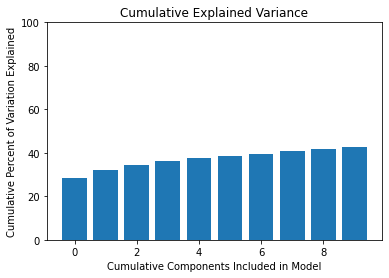

In [71]:
# initialize PCA:
# reduce features:
pca = PCA(n_components=10)
dense_corpus = gensim.matutils.corpus2dense(corpus, 10649)
reduced_features = pca.fit_transform(dense_corpus.T)

# display percent explained variance of the first ten components:
fig = plt.figure()
plt.bar(x=range(len(pca.explained_variance_ratio_)), height=np.cumsum(pca.explained_variance_ratio_)*100)
plt.ylim([0, 100])
plt.ylabel("Cumulative Percent of Variation Explained")
plt.xlabel("Cumulative Components Included in Model")
plt.title("Cumulative Explained Variance");

Unfortunately the first two components only seem to code for about 5% (if that) of the percent variation. This makes sense since the bog-of-words is massive, however this means that we cannot trust visual cluster, we'll need some empirical measure of clsuter goodness. 

In [72]:
import pandas as pd

loadings = pd.DataFrame(data=pca.components_, columns=id2word.values()).T

topics = pd.DataFrame()

for t in loadings.columns:
    topics[str(t)] = loadings[t].sort_values(ascending=False)[:10].index.tolist()
    
topics

,0,1,2,3,4,5,6,7,8,9
0,de,model,report,model,analysis,research,research,model,research,customer
1,et,learn,management,machine,analytical,analysis,learn,product,product,hopper
2,le,machine,support,solution,customer,client,employee,technology,customer,help
3,la,solution,skill,skill,model,skill,office,use,agoda,ai
4,donnees,customer,provide,learn,product,model,management,de,ai,million
5,pour,build,analyst,develop,insight,ability,machine,across,science,service
6,en,help,process,knowledge,stakeholder,learn,people,risk,ml,travel
7,avec,use,client,technique,statistical,statistical,health,information,security,canada
8,une,develop,project,service,support,health,risk,microsoft,partner,well
9,les,technology,ability,ai,depth,project,member,hopper,industry,tool


# SVD

In [91]:
from sklearn.decomposition import TruncatedSVD

svd_model = TruncatedSVD(n_components=6,         # num dimensions
                         algorithm='randomized',
                         n_iter=10)
svd_matrix = svd_model.fit_transform(dense_corpus.T)

In [92]:
svd_matrix[0].shape

(6,)

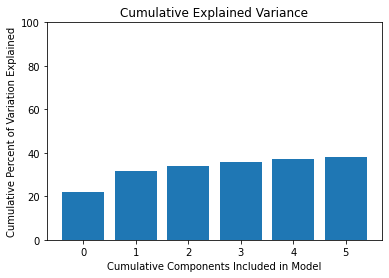

In [93]:
# display percent explained variance of the first ten components:
fig = plt.figure()
plt.bar(x=range(len(svd_model.explained_variance_ratio_)), height=np.cumsum(svd_model.explained_variance_ratio_)*100)
plt.ylim([0, 100])
plt.ylabel("Cumulative Percent of Variation Explained")
plt.xlabel("Cumulative Components Included in Model")
plt.title("Cumulative Explained Variance");

In [94]:
loadings = pd.DataFrame(data=svd_model.components_, columns=id2word.values()).T

topics = pd.DataFrame()

for t in loadings.columns:
    topics[str(t)] = loadings[t].sort_values(ascending=False)[:10].index.tolist()
    
topics

,0,1,2,3,4,5
0,de,de,learn,model,analysis,research
1,et,et,machine,solution,analytical,analysis
2,le,le,model,machine,customer,skill
3,la,la,science,skill,support,model
4,technology,donnees,engineering,learn,stakeholder,statistical
5,donnees,pour,build,develop,insight,ability
6,information,en,scientist,knowledge,depth,health
7,model,avec,ml,service,model,learn
8,pour,les,product,development,help,project
9,en,une,ai,technique,product,game


Need to remove french documents.

# LDA

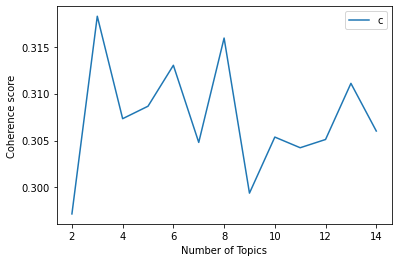

In [160]:
from gensim import corpora
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# determine optimal number of topics using coherence score:
coherence_vals = []
model_list =[]
start = 2
stop = 15
step = 1

for num_topics in range(start, stop, step):
    # make LDa model and calc coherence:
    model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v', processes=1)
    coherence_vals.append(coherence_model.get_coherence())
    
x = range(start, stop, step)
plt.plot(x, coherence_vals)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')

Not great results, but I guess there isn't that many different topics. Lets see the different topics.

In [161]:
best_model = model_list[coherence_vals.index(max(coherence_vals))]

best_model.print_topics()

[(0,
  '0.007*"information" + 0.007*"learn" + 0.006*"de" + 0.006*"technology" + 0.006*"model" + 0.006*"industry" + 0.005*"skill" + 0.005*"time" + 0.005*"client" + 0.005*"analysis"'),
 (1,
  '0.010*"technology" + 0.007*"de" + 0.007*"skill" + 0.006*"product" + 0.006*"service" + 0.005*"industry" + 0.005*"model" + 0.005*"help" + 0.005*"analysis" + 0.005*"solution"'),
 (2,
  '0.006*"science" + 0.006*"information" + 0.005*"learn" + 0.005*"model" + 0.005*"build" + 0.005*"skill" + 0.005*"technology" + 0.005*"solution" + 0.005*"time" + 0.005*"product"')]

In [165]:
len(model_list)

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


13

In [163]:
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

In [166]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model_list[10], corpus, id2word)
vis

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.012638 -0.002414       1        1  30.664354
10    -0.023928  0.005756       2        1  19.661013
9     -0.023761  0.003122       3        1  19.224755
5      0.001449 -0.017257       4        1   9.229447
0      0.024110  0.003415       5        1   6.821279
1     -0.021961 -0.003246       6        1   6.565230
7      0.011426  0.002379       7        1   2.582689
2      0.009738 -0.002243       8        1   2.249707
3      0.022216 -0.005796       9        1   1.235909
8      0.000641  0.002287      10        1   0.744284
6      0.015806  0.011538      11        1   0.665317
4     -0.003097  0.002460      12        1   0.356015, topic_info=             Term         Freq        Total Category  logprob  loglift
2235           de  1009.000000  1009.000000  Default  30.0000  30.0000
188         skill  1453.000000  1453.000000  Default  29.0000  29.0000
349    technology  1873.000000  1873.000000  Default  28.0000  28.0000
102   information  1490.000000  1490.000000  Default  27.0000  27.0000
802         model  1512.000000  1512.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
282          help     2.945039  1031.792022  Topic12  -5.6855  -0.2210
340       service     3.108096  1215.878403  Topic12  -5.6316  -0.3313
112         learn     3.093867  1612.748987  Topic12  -5.6362  -0.6183
181       science     2.960889  1271.325001  Topic12  -5.6801  -0.4244
163       product     2.852765  1188.743544  Topic12  -5.7173  -0.3944

[1037 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.370175  ability
0         2  0.180368  ability
0         3  0.195050  ability
0         4  0.090184  ability
0         5  0.044043  ability
...     ...       ...      ...
3687      1  0.318567      yep
3687      3  0.637133      yep
7604      2  0.118376     zola
7604      3  0.473504     zola
7604      6  0.118376     zola

[2958 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 11, 10, 6, 1, 2, 8, 3, 4, 9, 7, 5])